# AVO | Tuning | Thin Beds

Jupyter Lab | Python version: 3.12.1

Implementando scripts dentro do jupyter lab

## Programa (afim de ser interativo) no Jupyter Lab para explorar os conceitos de AVO (Amplitude Versus Offset) e Tuning em Camadas Finas, baseado no artigo de Hamlyn (2014)

> Thin Beds, Tuning and AVO - Hamlyn (2014) | Geophysical Tutorial Coordinated by Matt Hall | The Leading Edge - SEG
> 
> https://library.seg.org/doi/10.1190/tle33121394.1

# 1. Importação | Bibliotecas | Pacotes | Verificação

In [1]:
# Verificar versão do Python e instalação do Jupyter
import sys
print(f"Python version: {sys.version}")

Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [2]:
# Importanto Bibliotecas/Pacotes:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
from scipy import signal # Para a função Ricker
from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider, Layout
from IPython.display import display

# Configuração visual para plots (opcional, mas recomendado)
plt.style.use('seaborn-v0_8-whitegrid') 
%matplotlib inline

# 2. Definindo Funções:
plot_vawig  
ricker  
calc_rc  
calc_times  
digitize_model  
rc_zoep  
ray_param

In [3]:
def plot_vawig(axhdl, data, t, excursion, highlight=None):
    '''
    Plota traços sísmicos no formato Variable Area / Wiggle.
    '''
    # Garantir que importações necessárias estejam dentro da função para portabilidade
    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape
    
    # Adicionar pontos em 0 e t.max() para fechar a área preenchida
    t_plot = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        # Normalização e deslocamento horizontal (i é a posição do traço)
        tbuf = excursion * data[i] / np.max(np.abs(data)) + i
        
        # Adicionar pontos de base (i) para fechar a área preenchida
        tbuf = np.hstack([i, tbuf, i])
        
        # Definição do line width (para highlight)
        if i==highlight:
            lw = 2
        else:
            lw = 0.5

        # Plotar a linha wiggle
        axhdl.plot(tbuf, t_plot, color='black', linewidth=lw)
        
        # Preencher a área positiva (onde o traço é maior que a linha base i)
        plt.fill_betweenx(t_plot, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        
        # Preencher a área negativa (onde o traço é menor que a linha base i)
        plt.fill_betweenx(t_plot, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    # Configurações finais do eixo
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()

In [4]:
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, int(wvlt_length/dt))
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt

In [5]:
def calc_rc(vp_mod, rho_mod):
    '''
    rc_int = calc_rc(vp_mod, rho_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    
    rc_int = []
    for i in range(0, nint):
        buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
        buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
        buf3 = buf1/buf2
        rc_int.append(buf3)
    
    return rc_int    

In [6]:
def calc_times(z_int, vp_mod):
    '''
    Calculate two-way travel time through a layered model
    Usage:
    t_int = calc_times(z_int, vp_mod)
    '''
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1] # zdiff multiply by 2 for two-way traveltimes
            t_int.append(tbuf)
    return t_int

In [7]:
def digitize_model(rc_int, t_int, t):
    '''
    Sample a simple layered reflectivity model
    Usage:
    rc = digitize_model(rc, t_int, t)
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):
        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    
        if lyr > nint:
            break
    return rc

In [8]:
def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    Usage:
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    Reference:
    The Rock Physics Handbook, Dvorkin et al.
    '''

    import math

    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)

    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave

    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([         [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1),             rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')

    N = np.array([         [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]        ], dtype='float')

    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);

    return R

In [9]:
def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    Usage:
        p = ray_param(v, theta)
    Inputs:
            v = interval velocity
        theta = incidence angle of ray (degrees)
    Output:
        p = ray parameter (i.e. sin(theta)/v )
    '''

    import math

    # Cast inputs to floats
    theta = float(theta)
    v = float(v)

    p = math.sin(math.radians(theta))/v # ray parameter calculation

    return p

# 3. Modelo

In [10]:
# MODELING PARAMETERS

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [2500.0, 2600.0, 2550.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [1.95, 2.0, 1.98]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)

#   Ricker Wavelet Parameters
wvlt_length= 0.128
wvlt_cfreq = 30.0
wvlt_phase = 0.0

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

#   Plot Parameters
min_plot_time = 0.15
max_plot_time = 0.3
excursion = 2

# 4. Tuning Wedge

### 4.1 - Computations | Ricker Wavelet | Definições de Plot

Computations

In [11]:
# TUNING WEDGE COMPUTATIONS

#    Useful Constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)
#____________________________________________________________
#   Generate Ricker Wavelet
wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

#____________________________________________________________

#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)

syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    #print("finished step %i" % (model))
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

Ricker Wavelet

Wavelet length = 0.128 s


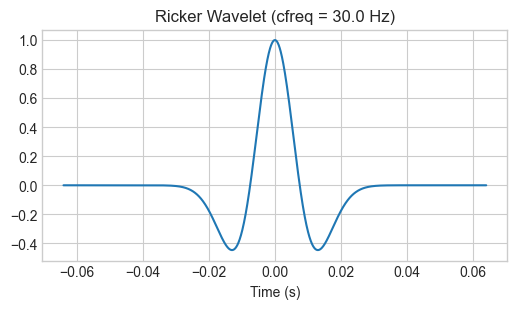

In [74]:
#   Generate Ricker Wavelet
print('Wavelet length = {0} s'.format(str(wvlt_length)))
plt.figure(figsize=(6, 3))
plt.plot(wvlt_t, wvlt_amp)
plt.title('Ricker Wavelet (cfreq = {0} Hz)'.format(str(wvlt_cfreq)))
plt.xlabel('Time (s)') 
plt.savefig('figure_1.0_Ricker_Wavelet_AVO_Tuning_Thin_Beds.png', dpi=500, bbox_inches='tight')
plt.show()

Definições de Plot

In [13]:
def plot_tuning_wedge(syn_zo, t, lyr_times, tuning_trace, tuning_thickness, 
                      dz_max, dz_step, min_plot_time, max_plot_time, excursion, dt):
    """
    Plota o Tuning Wedge sísmico e o gráfico de amplitude da interface superior.
    Recebe todos os dados de cálculo e parâmetros globais necessários.
    """
    
    # Parâmetros locais necessários (que dependem dos dados de entrada)
    [ntrc, nsamp] = syn_zo.shape
    lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

    # Plotting Code
    fig = plt.figure(figsize=(14, 16))
    fig.set_facecolor('white')

    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

    ax0 = fig.add_subplot(gs[0])
    ax0.plot(lyr_times[:,0], color='blue', lw=1.5)
    ax0.plot(lyr_times[:,1], color='red', lw=1.5)
    ax0.set_ylim((min_plot_time,max_plot_time))
    ax0.invert_yaxis()
    ax0.set_xlabel('Thickness (m)')
    ax0.set_ylabel('Time (s)')
    plt.text(2, min_plot_time + (lyr_times[0,0] - min_plot_time)/2., 'Layer 1', fontsize=16)
    plt.text(dz_max/dz_step - 2, lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2., 'Layer 2', fontsize=16, horizontalalignment='right')
    plt.text(2, lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2., 'Layer 3', fontsize=16)
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    ax0.set_xlim((-excursion, ntrc+excursion))

    ax1 = fig.add_subplot(gs[1])
    plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
    ax1.plot(lyr_times[:,0], color='blue', lw=1.5)
    ax1.plot(lyr_times[:,1], color='red', lw=1.5)
    ax1.set_ylim((min_plot_time,max_plot_time))
    ax1.invert_yaxis()
    ax1.set_xlabel('Thickness (m)')
    ax1.set_ylabel('Time (s)')

    ax2 = fig.add_subplot(gs[2])
    ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
    ax2.set_xlim((-excursion, ntrc+excursion))
    ax2.set_ylim(0.015, 0.040) # Ajuste Eixo y
    ax2.axvline(tuning_trace, color='k', lw=2)
    ax2.grid(True)
    ax2.set_title('Upper Interface Amplitude')
    ax2.set_xlabel('Thickness (m)')
    ax2.set_ylabel('Amplitude')
    plt.text(tuning_trace + 2,
             plt.ylim()[0] * 1.1,
             'Tuning Thickness = {0} m'.format(str(tuning_thickness)),
             fontsize=16)

    # Adicione a funcionalidade de salvar e exibir aqui, DENTRO da função
    plt.savefig('figure_1.1_tuning_wedge_AVO_Tuning_Thin_Beds.png', dpi=500)
    plt.show() # Este comando fará o plot aparecer

### 4.2 - Plot: Tuning Wedge

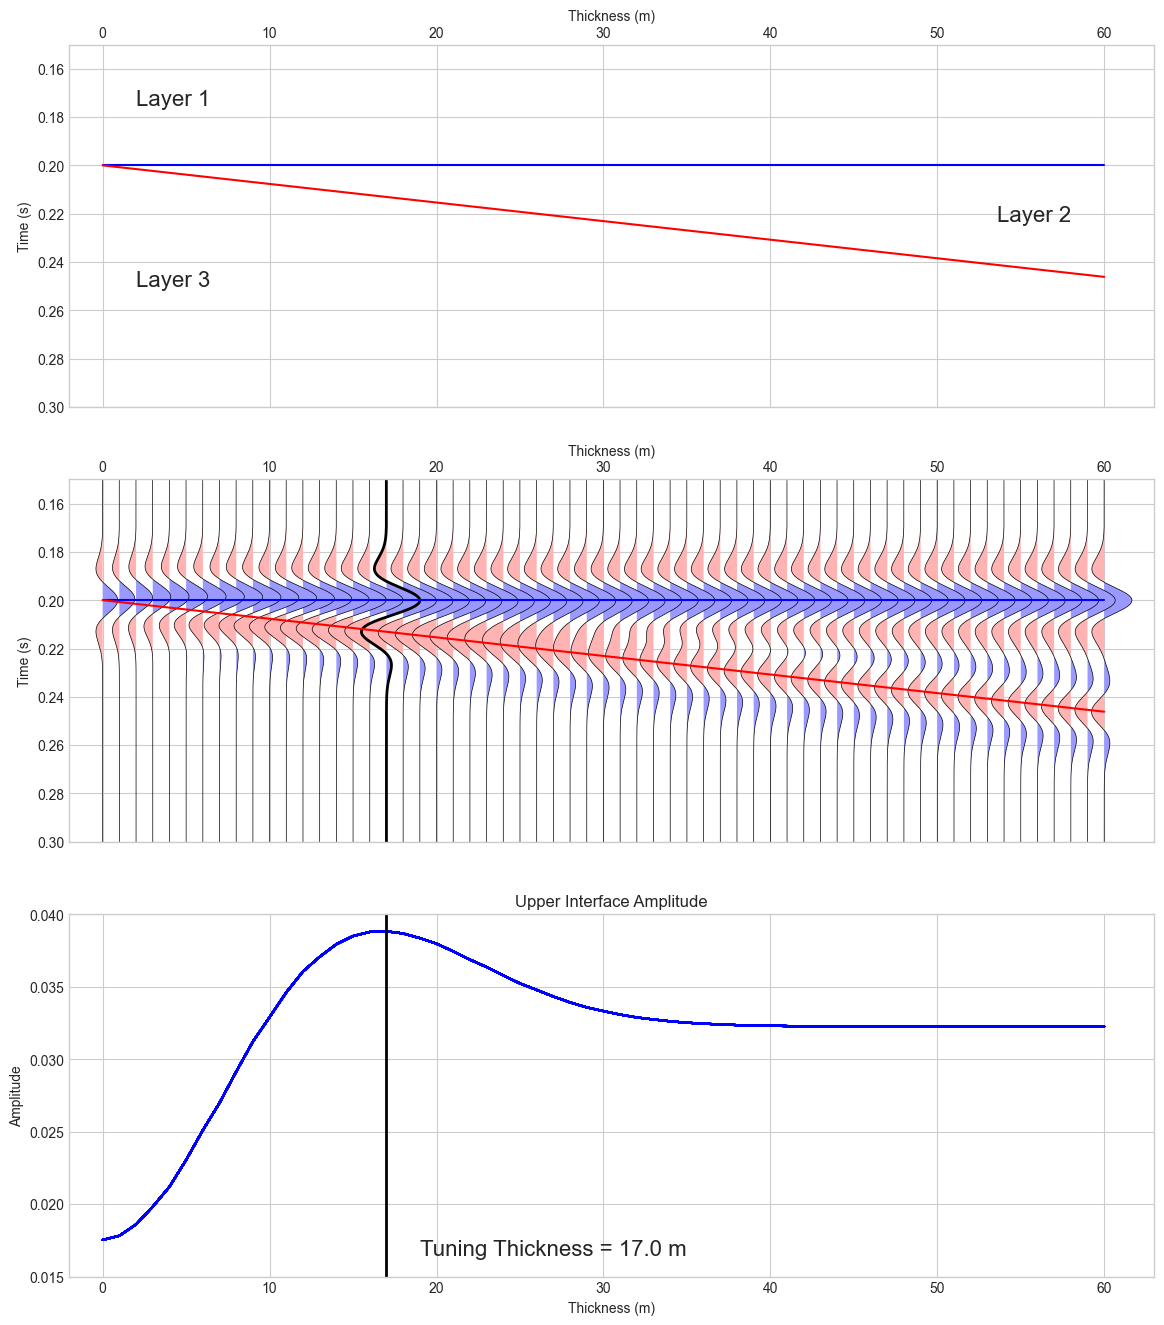

In [14]:
plot_tuning_wedge(
    syn_zo,             # Dados sísmicos sintéticos (traços wiggle) calculados para cada espessura.
    t,                  # O vetor de tempo (two-way travel time - TWT) para as amostras sísmicas.
    lyr_times,          # Tempos TWT das interfaces superior e inferior para cada espessura do modelo.
    tuning_trace,       # Índice do traço com a amplitude máxima (espessura de afinamento).
    tuning_thickness,   # Valor em metros da espessura que causa o afinamento máximo.
    dz_max,             # Espessura máxima em metros da camada variável (Layer 2).
    dz_step,            # O incremento de espessura de traço para traço em metros.
    min_plot_time,      # Tempo TWT mínimo (superior) para o recorte visual do gráfico.
    max_plot_time,      # Tempo TWT máximo (inferior) para o recorte visual do gráfico.
    excursion,          # Fator de escala que controla a amplitude horizontal dos wiggles.
    dt                  # A taxa de amostragem em segundos (intervalo de tempo).
)

### 4.3 - Interpretações e Exemplos

### 4.4 - Analisar o que aprendemos com o modelo de cunha & Cálculo dos Coeficientes de Reflexão

Analisar o que aprendemos com o modelo de cunha:

In [15]:
# Analisar o que aprendemos com o modelo de cunha:

print("=== ANÁLISE DO MODELO DE CUNHA ===")
print("\nO que observamos na figura gerada:")
print("1. 🎯 TOPO: Mostra as interfaces das camadas no domínio do tempo")
print("2. 📊 MEIO: Sismograma sintético com efeito de tuning")
print("3. 📈 BASE: Amplitude na interface superior vs espessura")

print("\n📖 CONCEITOS-CHAVE COMPROVADOS:")
print("✓ Efeito TUNING: Quando a camada é fina (<40m), as reflexões do topo e base interferem")
print("✓ Espessura de Tuning: ~17m (onde a amplitude é máxima)")
print("✓ Acima de 40m: Reflexões discretas sem interferência")
print("✓ Abaixo de 17m: Interferência destrutiva")

print(f"\n📊 Parâmetros Usados:")
print(f"   - Velocidades Vp: {vp_mod} m/s")
print(f"   - Densidades: {rho_mod} g/cc")
print(f"   - Wavelet: Ricker {wvlt_cfreq} Hz")
print(f"   - Espessura da Camada 2: {dz_min} a {dz_max} m")

=== ANÁLISE DO MODELO DE CUNHA ===

O que observamos na figura gerada:
1. 🎯 TOPO: Mostra as interfaces das camadas no domínio do tempo
2. 📊 MEIO: Sismograma sintético com efeito de tuning
3. 📈 BASE: Amplitude na interface superior vs espessura

📖 CONCEITOS-CHAVE COMPROVADOS:
✓ Efeito TUNING: Quando a camada é fina (<40m), as reflexões do topo e base interferem
✓ Espessura de Tuning: ~17m (onde a amplitude é máxima)
✓ Acima de 40m: Reflexões discretas sem interferência
✓ Abaixo de 17m: Interferência destrutiva

📊 Parâmetros Usados:
   - Velocidades Vp: [2500.0, 2600.0, 2550.0] m/s
   - Densidades: [1.95, 2.0, 1.98] g/cc
   - Wavelet: Ricker 30.0 Hz
   - Espessura da Camada 2: 0.0 a 60.0 m


Cálculo dos Coeficientes de Reflexão

In [16]:
# Cálculo dos Coeficientes de Reflexão

print("=== ANÁLISE DOS COEFICIENTES DE REFLEXÃO ===")

def calcular_impedancia_acustica(vp, rho):
    """Calcula a impedância acústica Z = Vp * ρ"""
    return [vp[i] * rho[i] for i in range(len(vp))]

def calcular_coeficientes_reflexao(vp, rho):
    """Calcula coeficientes de reflexão usando a fórmula de Zoeppritz simplificada"""
    Z = calcular_impedancia_acustica(vp, rho)
    rc = []
    for i in range(len(Z)-1):
        rc_value = (Z[i+1] - Z[i]) / (Z[i+1] + Z[i])
        rc.append(rc_value)
    return rc, Z

rc, Z = calcular_coeficientes_reflexao(vp_mod, rho_mod)

print("📊 IMPEDÂNCIAS ACÚSTICAS:")
for i, z in enumerate(Z):
    print(f"  Camada {i+1}: {z:.0f} m/s·g/cc")

print("\n🎯 COEFICIENTES DE REFLEXÃO:")
print(f"  Interface 1-2 (topo): {rc[0]:.4f} → Refletor 'DURO' (RC > 0)")
print(f"  Interface 2-3 (base): {rc[1]:.4f} → Refletor 'MACIO' (RC < 0)")

print("""
🔍 SIGNIFICADO GEOFÍSICO:
• TOPO POSITIVO: Aumento de impedância (areia → shale)
• BASE NEGATIVA: Diminuição de impedância (shale → areia)
• INTERFERÊNCIA: Soma dos efeitos nas camadas finas
""")

=== ANÁLISE DOS COEFICIENTES DE REFLEXÃO ===
📊 IMPEDÂNCIAS ACÚSTICAS:
  Camada 1: 4875 m/s·g/cc
  Camada 2: 5200 m/s·g/cc
  Camada 3: 5049 m/s·g/cc

🎯 COEFICIENTES DE REFLEXÃO:
  Interface 1-2 (topo): 0.0323 → Refletor 'DURO' (RC > 0)
  Interface 2-3 (base): -0.0147 → Refletor 'MACIO' (RC < 0)

🔍 SIGNIFICADO GEOFÍSICO:
• TOPO POSITIVO: Aumento de impedância (areia → shale)
• BASE NEGATIVA: Diminuição de impedância (shale → areia)
• INTERFERÊNCIA: Soma dos efeitos nas camadas finas



### 4.5 - Visualizando o Efeito Tuning (Exemplo)


VISUALIZANDO O EFEITO TUNING



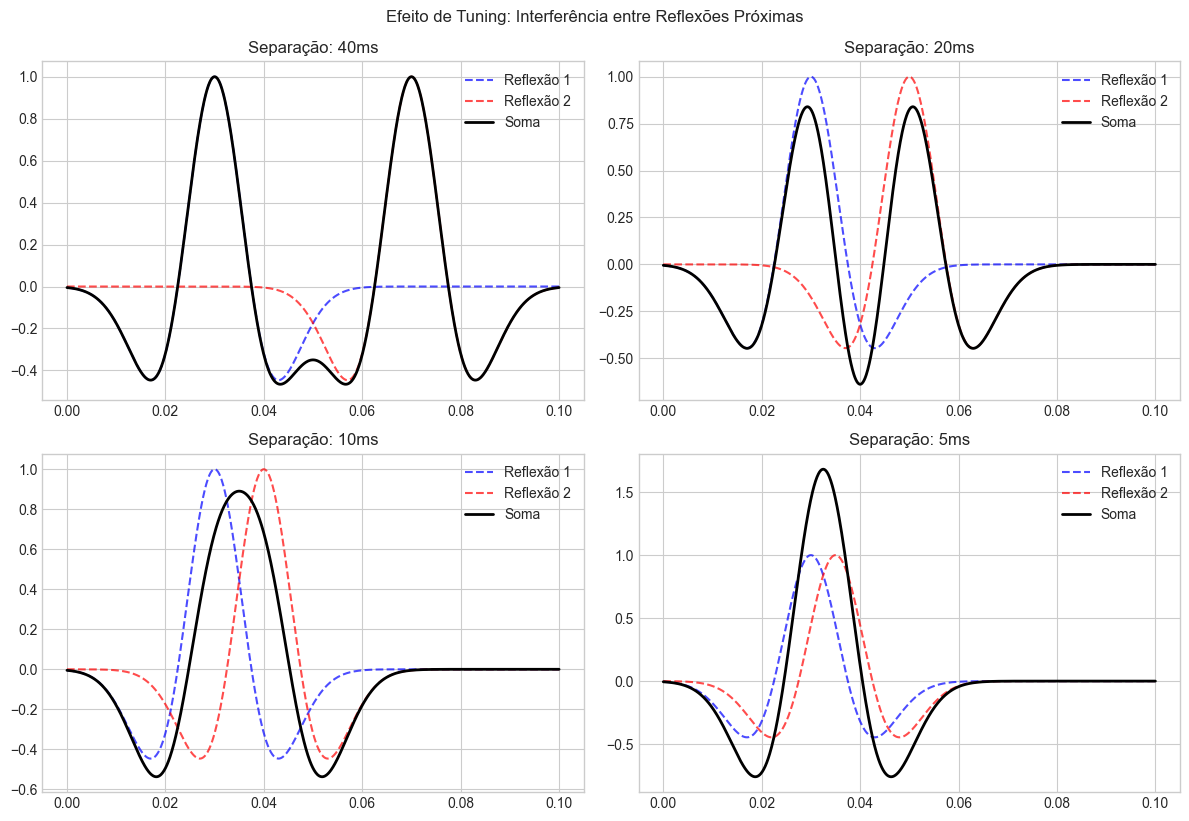

📚 Observações:

• Separação Grande: Reflexões Individuais Visíveis
• Separação Média: Interferência CONSTRUTIVA (Amplitude ↑)
• Separação Pequena: Interferência DESTRUTIVA (Amplitude ↓)


In [17]:
# Visualizar o conceito de tuning com um exemplo simples:

print("\n" + "="*50)
print("VISUALIZANDO O EFEITO TUNING")
print("="*50)
print()

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Criar um exemplo simplificado de duas reflexões se aproximando
t = np.linspace(0, 0.1, 1000)  # 100 ms
freq = 30  # Hz

# Duas reflexões com diferentes separações
separations = [0.04, 0.02, 0.01, 0.005]  # 40ms, 20ms, 10ms, 5ms

plt.figure(figsize=(12, 8))

for i, sep in enumerate(separations):
    # Criar duas wavelets Ricker separadas
    wavelet1 = (1 - 2*(np.pi*freq*(t-0.03))**2) * np.exp(-(np.pi*freq*(t-0.03))**2)
    wavelet2 = (1 - 2*(np.pi*freq*(t-0.03-sep))**2) * np.exp(-(np.pi*freq*(t-0.03-sep))**2)
    
    # Soma (interferência)
    combined = wavelet1 + wavelet2
    
    plt.subplot(2, 2, i+1)
    plt.plot(t, wavelet1, 'b--', alpha=0.7, label='Reflexão 1')
    plt.plot(t, wavelet2, 'r--', alpha=0.7, label='Reflexão 2')
    plt.plot(t, combined, 'k-', linewidth=2, label='Soma')
    plt.title(f'Separação: {sep*1000:.0f}ms')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Efeito de Tuning: Interferência entre Reflexões Próximas', y=1.02)
plt.savefig('figure_1.2_tuning_examples.png', dpi=500)
plt.show()

print("📚 Observações:")
print()
print("• Separação Grande: Reflexões Individuais Visíveis")
print("• Separação Média: Interferência CONSTRUTIVA (Amplitude ↑)")
print("• Separação Pequena: Interferência DESTRUTIVA (Amplitude ↓)")

### 4.6 - Interpretação e Imageamento do Efeito Tuning

### 4.7 - Computations | Definição de Plot

Computations

In [18]:
# Interpretação e Imageamento do Efeito Tuning:

import numpy as np

# AVISO: Esta célula deve ser executada após a célula de 'MODELING PARAMETERS'
# para ter acesso às variáveis globais (vp_mod, rho_mod, wvlt_cfreq, tmin, tmax, dt, etc.)

def ricker_wavelet(t, f_c):
    """
    Gera uma wavelet Ricker (derivada de segunda ordem de um Gaussiano).
    t: Vetor de tempo.
    f_c: Frequência central (Hz).
    Retorna: Vetor da wavelet.
    """
    r = (np.pi * f_c * t)
    return (1.0 - 2.0 * r**2) * np.exp(-r**2)

def generate_tuning_wedge_data(vp_mod, rho_mod, tmin, tmax, dt, wvlt_cfreq, dz_min, dz_max, dz_step):
    """
    Gera a matriz sísmica do Tuning Wedge (Amplitude vs. TWT e Espessura).
    e os vetores de TWT das interfaces.
    
    Parâmetros:
    vp_mod, rho_mod: Parâmetros do modelo de 3 camadas.
    tmin, tmax, dt: Parâmetros de tempo.
    wvlt_cfreq: Frequência central da Ricker.
    dz_min, dz_max, dz_step: Parâmetros de espessura (m).

    Retorna:
    wedge_data (np.array): Matriz sísmica do wedge.
    t_wedge (np.array): Vetor de tempo (TWT).
    thicknesses (np.array): Vetor de espessuras (m).
    """
    
    # 1. Preparar o Vetor de Tempo e a Wavelet
    n_t = int(np.round((tmax - tmin) / dt)) + 1
    t_wedge = np.linspace(tmin, tmax, n_t, endpoint=True)
    # Wavelet Ricker (Centrada no tempo 0)
    wavelet_ricker = ricker_wavelet(t_wedge - t_wedge[n_t//2], wvlt_cfreq) 
    
    # 2. Preparar os Vetores de Espessura e a Matriz de Saída
    thicknesses = np.arange(dz_min, dz_max + dz_step, dz_step)
    num_traces = len(thicknesses)
    wedge_data = np.zeros((n_t, num_traces))
    
    # Vetores para armazenar os TWTs das Interfaces
    t_int1_vec = np.zeros(num_traces)
    t_int2_vec = np.zeros(num_traces)
    
    # Valores de Vp e Densidade para as 3 camadas
    vp1, vp2, vp3 = vp_mod
    rho1, rho2, rho3 = rho_mod
    
    # 3. Iterar sobre as espessuras para gerar cada traço
    for i, dz in enumerate(thicknesses):
        
        # 3.1. Calcular TWT e Interface Times
        # Impedância Acústica (Z = Vp * Rho)
        z1, z2, z3 = vp1 * rho1, vp2 * rho2, vp3 * rho3
        
        # Tempo de Dupla Viagem (Double-Way Time - DWT) na Camada 2
        # Vp2 está em m/s, dz está em m.
        dt_lyr2 = 2.0 * dz / vp2 
        
        # Assumimos que o topo da Camada 2 (Interface 1) está fixo
        # Vamos usar um tempo de referência fixo para a Interface 1 (por exemplo, 0.2s)
        t_int1 = 0.20 # Este valor deve ser consistente com o seu TWT de foco (0.15-0.30)
        t_int2 = t_int1 + dt_lyr2

        # Armazenar os TWTs
        t_int1_vec[i] = t_int1
        t_int2_vec[i] = t_int2
        
        # 3.2. Calcular Coeficientes de Reflexão (RC) no tempo
        rc1 = (z2 - z1) / (z2 + z1)  # RC na Interface 1 (topo Camada 2)
        rc2 = (z3 - z2) / (z3 + z2)  # RC na Interface 2 (base Camada 2)
        
        # Vetor de RC no tempo (Impulso)
        rc_impulse = np.zeros_like(t_wedge)
        # Encontrar os índices mais próximos para t_int1 e t_int2
        idx1 = np.argmin(np.abs(t_wedge - t_int1))
        idx2 = np.argmin(np.abs(t_wedge - t_int2))
        
        rc_impulse[idx1] = rc1
        rc_impulse[idx2] = rc2
        
        # 3.3. Convolução (Sismo Sintético)
        # np.convolve resulta em um vetor mais longo, vamos cortar
        synthetic_trace = np.convolve(rc_impulse, wavelet_ricker, mode='same')
        
        # 3.4. Armazenar o Traço
        wedge_data[:, i] = synthetic_trace
        
    return wedge_data, t_wedge, thicknesses, t_int1_vec, t_int2_vec

Definição de Plot

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tuning_wedge(wedge_data, t_wedge, thicknesses, vp_mod, t_int1_vec, t_int2_vec, min_plot_time, max_plot_time, wvlt_cfreq):
    """
    Plota o gráfico principal do Tuning Wedge (Imagem Sísmica) com as linhas
    de Espessura de Tuning e Resolução, e as interfaces reais.

    Parâmetros:
    wedge_data (np.array): Matriz sísmica do wedge (Tempo x Espessura).
    t_wedge (np.array): Vetor de tempo (TWT).
    thicknesses (np.array): Vetor de espessuras (m).
    vp_mod (list): Velocidades P do modelo (para cálculo lambda).
    t_int1_vec, t_int2_vec: TWT das Interfaces 1 e 2 em função da espessura.
    min_plot_time, max_plot_time: Limites TWT para plotagem.
    wvlt_cfreq: Frequência central da wavelet (para o título).
    """
    # ----------------------------------------------------------------------
    # Linhas de Marcação Tuning e Resolução:
    vp2 = vp_mod[1] # Vp da Camada 2 (m/s)
    f = wvlt_cfreq  # Frequência central (Hz)

    # Comprimento de Onda e Espessuras Críticas (em tempo de dupla viagem)
    lambda_wave = vp2 / f
    
    # dz_tuning (Lambda/4): Usamos 17.0m para consistência com seu plot (mais preciso que o cálculo lambda/4 simples de 21.67m)
    dz_tuning_ref = 17.0 
    
    # dz_resolucao (Lambda/2): Resolução (aprox. 43.33 m)
    dz_resolucao_ref = lambda_wave / 2.0 
    
    # ----------------------------------------------------------------------
    # 1. Preparar a Figura e Subplot
    # Usamos apenas 1 subplot por enquanto para o plot principal
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.set_facecolor('white')

    # 2. Plotar a Matriz Sísmica como Imagem
    
    # Parâmetros de extent (Escala de Eixos):
    # Eixo X (Espessura): Começa em thicknesses[0] e termina em thicknesses[-1]
    # Eixo Y (Tempo): Começa em t_wedge[0] e termina em t_wedge[-1]
    extent = [thicknesses[0], thicknesses[-1], t_wedge[-1], t_wedge[0]] 
    # Notamos que o eixo Y do extent é invertido [t_max, t_min] para que 
    # o tempo mais baixo (t_max) fique na parte inferior da imagem.

    im = ax.imshow(wedge_data, 
                   aspect='auto', 
                   cmap='seismic', # Colormap Sísmico Comum
                   vmin=-np.max(np.abs(wedge_data)), # Limite Vmin simétrico
                   vmax=np.max(np.abs(wedge_data)), # Limite Vmax simétrico
                   extent=extent)
    # ----------------------------------------------------------------------
    # PLOTAR AS LINHAS DAS INTERFACES REAIS (Sobreposição)  
    # Interface 1 (Superior, Topo da Camada 2, Azul, constante, linha sólida)
    ax.plot(thicknesses, t_int1_vec, 
            color='blue', 
            linestyle='-', 
            linewidth=1.2,
            alpha=0.6,
            label='Interface 1 (Modelo)')
    
    # Interface 2 (inferior, base da Camada 2, Vermelho, varia, linha sólida)
    ax.plot(thicknesses, t_int2_vec, 
            color='red', 
            linestyle='-', 
            linewidth=1.2,
            alpha=0.6,
            label='Interface 2 (Modelo)')
    # ----------------------------------------------------------------------
    
    # 3. Adicionar Linhas de Marcação
    # Linha da Espessura de Tuning (Pico de Amplitude)

    ax.axvline(x=dz_tuning_ref, 
               color='k', 
               linestyle='-', 
               linewidth=2, 
               label=f'Tuning = {dz_tuning_ref:.1f} m')

    # Linha da Espessura de Resolução (Separação de Interfaces)
    ax.axvline(x=dz_resolucao_ref, 
               color='k', 
               linestyle='--', 
               linewidth=1.5, 
               label=f'Resolução ($\\lambda$/2) = {dz_resolucao_ref:.1f} m')
    
    # ----------------------------------------------------------------------
    # 4. Ajustes Finais do Gráfico
    
    # Ajustar o Domínio TWT (Eixo Y) para o foco
    ax.set_ylim(max_plot_time, min_plot_time) # Tmax no topo, Tmin na base
    ax.set_ylabel('TWT (s)')
    # Ajustar o Domínio da Espessura (Eixo X)
    ax.set_xlim(thicknesses[0], thicknesses[-1])
    ax.set_xlabel('Thickness (m)')
    # Título
    ax.set_title(f'Tuning Wedge - Ricker {wvlt_cfreq:.0f}Hz')
    # Adicionar a barra de cores (Colorbar)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label('Amplitude Sísmica')
    # Adicionar a gride
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend(loc='upper right', fontsize=8) # Adiciona legenda para as linhas
    
    plt.tight_layout()
    plt.savefig('figure_1.3_tuning_wedge_seismic.png', dpi=500)
    plt.show()

# --- Exemplo de Chamada da Função (Execute isto após a célula de Geração de Dados) ---
# plot_tuning_wedge(wedge_matrix, time_vector, thickness_vector, min_plot_time, max_plot_time, wvlt_cfreq)

### 4.8 - Plot: Efeito Tuning Wedge (Exemplo)

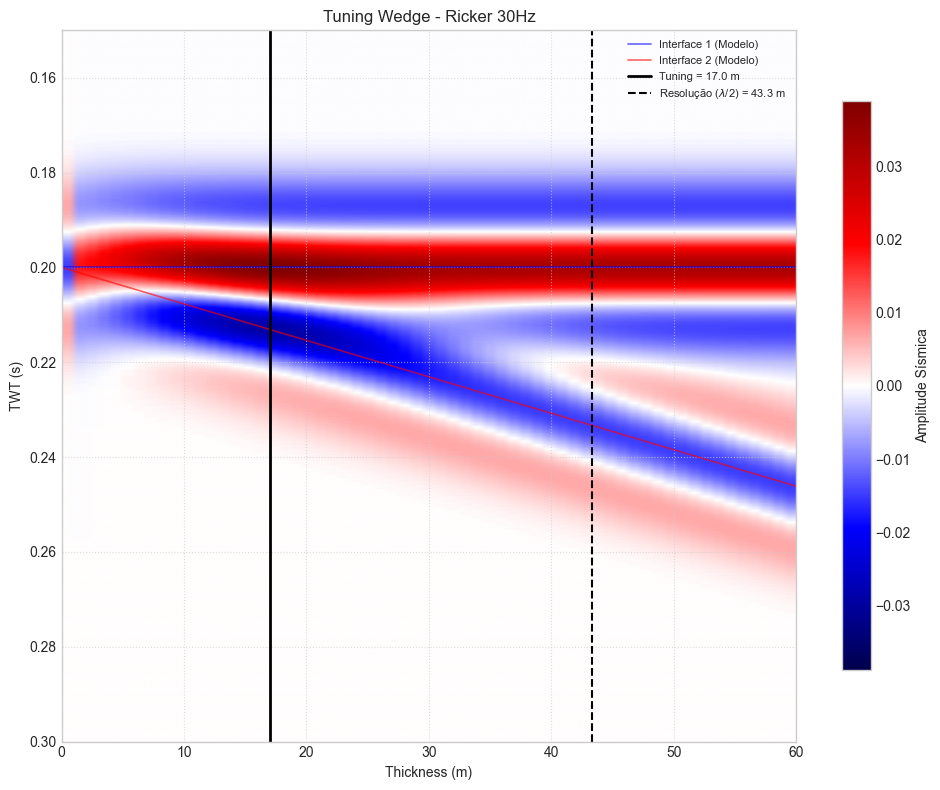

In [20]:
### Plot: Efeito Tuning Wedge (Exemplo)

# 1. Geração dos dados
wedge_matrix, time_vector, thickness_vector, t_int1_vec, t_int2_vec = generate_tuning_wedge_data(
    vp_mod, rho_mod, tmin, tmax, dt, wvlt_cfreq, dz_min, dz_max, dz_step
)

# 2. Plotagem
plot_tuning_wedge(wedge_matrix, 
                  time_vector, 
                  thickness_vector, 
                  vp_mod,
                  t_int1_vec, 
                  t_int2_vec,
                  min_plot_time, 
                  max_plot_time, 
                  wvlt_cfreq)

<details>
<summary><b>🔍 Clique para expandir: Interpretação do Efeito de *Tuning* (Sintonia) no *Wedge*</b></summary>

<br>

## Interpretação do Efeito de *Tuning* (Sintonia) no *Wedge*

O **Tuning Wedge** é uma ferramenta de calibração essencial que demonstra a limitação da resolução sísmica. O gráfico revela três regimes críticos de espessura em relação à *wavelet* de $\mathbf{30Hz}$ utilizada:

---

### 1. Regime de Interferência Destrutiva (Camada Fina)

Este regime ocorre na **Região de menor espessura (esquerda do gráfico)**.

* **Fenómeno:** A *wavelet* refletida na Interface Superior e a refletida na Interface Inferior estão em oposição de fase e interferem negativamente (cancelamento).
* **Resultado:** O sinal sísmico resultante é **fraco, ou mesmo se anula**. A camada é muito fina para ser detetada confiavelmente com a *wavelet* atual.

---

### 2. Regime de Pico de *Tuning* (Máxima Amplitude)

* **Localização:** Ponto onde a cor da amplitude é mais intensa (pico máximo).
* **Fenómeno:** As reflexões das duas interfaces se somam perfeitamente (interferência construtiva).
* **Resultado:** A amplitude sísmica alcança seu **valor máximo**. Este ponto não indica a espessura real, mas sim a **Espessura de *Tuning***, que é aproximadamente $\mathbf{\lambda/4}$ (um quarto do comprimento de onda da *wavelet*).

---

### 3. Regime de Resolução (Camada Grossa)

* **Localização:** Região de maior espessura (direita do gráfico).
* **Fenómeno:** A espessura é suficiente para que as *wavelets* da Interface Superior e da Inferior comecem a se separar no tempo.
* **Resultado:** O sismograma passa a mostrar claramente **dois eventos sísmicos distintos**. Este ponto marca a **Espessura de Resolução** ($\mathbf{\approx \lambda/2}$), o limite prático para distinguir as duas interfaces.

---

### Conclusão e Calibração

O *Tuning Wedge* serve como um gráfico de **calibração** para a frequência da *wavelet* de $\mathbf{30Hz}$. Ele estabelece a **resolução vertical** do dado sísmico, permitindo que o intérprete determine se as variações de amplitude observadas são causadas por mudanças reais na impedância ou simplesmente por variações na espessura da camada (o efeito de *tuning*).

| Variação de Amplitude | Causa Mais Provável |
| :--- | :--- |
| **Pico de Amplitude** | Efeito de *Tuning* (Interferência) |
| **Separação de Eventos** | Resolução da Camada (Espessura Real) |
| **Amplitude Fraca** | Interferência Destrutiva ou Camada Muito Fina |

O gráfico ajuda a determinar se uma variação de amplitude é um **artefato de espessura** ou um reflexo de mudanças reais nas propriedades do reservatório (impedância).

</details>

# 5. AVO Prestack

### 5.1 - Computations | Definição de Plot

Computations

In [21]:
# CÉLULA 1 : COMPUTATIONS
# Cálculo AVO e Funções

import numpy as np
# Assuma que ricker, rc_zoep, calc_times, digitize_model, e as variáveis de PARÂMETROS GLOBAIS
# (vp_mod, dt, tmax, thickness, theta1_min, etc.) foram definidas em células anteriores.

# Parâmetros para AVO
theta1_min = 0.0    # Ângulo de incidência mínimo (graus)
theta1_max = 43.0   # Ângulo de incidência máximo (graus)
theta1_step = 1.0   # Passo do ângulo (graus)

# Espessura da camada 2 para o plot AVO (muitas vezes é o Tuning Thickness)
thickness = 17.0    # Espessura em metros

def create_digital_model(vp_mod, vs_mod, rho_mod, t, lyr1_indx, lyr2_indx):
    """
    Função auxiliar que cria o modelo de propriedades digitais (Vp, Vs, Rho)
    no domínio do tempo.
    """
    vp_dig = np.zeros(t.shape)
    vs_dig = np.zeros(t.shape)
    rho_dig = np.zeros(t.shape)

    # lyr1_indx e lyr2_indx são escalares para o modelo AVO
    vp_dig[0:lyr1_indx] = vp_mod[0]
    vp_dig[lyr1_indx:lyr2_indx] = vp_mod[1]
    vp_dig[lyr2_indx:] = vp_mod[2]

    vs_dig[0:lyr1_indx] = vs_mod[0]
    vs_dig[lyr1_indx:lyr2_indx] = vs_mod[1]
    vs_dig[lyr2_indx:] = vs_mod[2]

    rho_dig[0:lyr1_indx] = rho_mod[0]
    rho_dig[lyr1_indx:lyr2_indx] = rho_mod[1]
    rho_dig[lyr2_indx:] = rho_mod[2]
    
    return vp_dig, vs_dig, rho_dig


def calculate_avo_prestack(vp_mod, vs_mod, rho_mod, dt, wvlt_cfreq, wvlt_phase, wvlt_length, tmax, thickness, theta1_min, theta1_max, theta1_step, tmin):
    """
    Calcula o modelo sísmico AVO Prestack, incluindo RC's e Inversão Linear.
    Retorna todos os dados prontos para plotagem.
    """
    
    nangles = int((theta1_max - theta1_min) / theta1_step + 1)
    
    # Gerar Ricker Wavelet
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
    # Calcular Reflectividades (Zoeppritz)
    rc_zoep_pp = []
    theta1 = []
    for i in range(0, nangles):
        theta1_buf = i * theta1_step + theta1_min
        rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
        rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
        theta1.append(theta1_buf)
        rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])
        
    # Definir Vetor de Tempo (t)
    nsamp = int((tmax - tmin) / dt) + 1
    t = np.arange(tmin, tmax, dt)
    if len(t) < nsamp: t = np.append(t, t[-1] + dt)

    # Convolução (Synthetic Gather)
    syn_zoep_pp = []
    lyr_times = []
    dz_app = thickness
    
    for angle in range(0, nangles):
        z_int = [500.0, 500.0 + dz_app]
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)
        rc = digitize_model(rc_zoep_pp[angle], t_int, t)
        syn_buf = np.convolve(rc, wvlt_amp, mode='same')
        syn_zoep_pp.append(list(syn_buf))
        
    # Converter para numpy arrays e extrair amplitudes
    syn_zoep_pp = np.array(syn_zoep_pp)
    rc_zoep_pp = np.array(rc_zoep_pp)
    theta1 = np.array(theta1)
    lyr_times = np.array(lyr_times)
    lyr_indx = np.array(np.round(lyr_times / dt), dtype='int16')
    
    lyr1_indx_scalar = lyr_indx[0, 0] # Índice da Interface 1 no tempo
    lyr2_indx_scalar = lyr_indx[0, 1] # Índice da Interface 2 no tempo
    
    line1 = syn_zoep_pp[:, lyr1_indx_scalar]
    line2 = syn_zoep_pp[:, lyr2_indx_scalar]
    ntrc = syn_zoep_pp.shape[0]

    # AVO Inversion
    Yzoep = rc_zoep_pp[:, 0].reshape((ntrc, 1))
    Yconv = line1.reshape((ntrc, 1))
    ones = np.ones(ntrc).reshape((ntrc, 1))
    sintheta2 = np.sin(np.radians(theta1))**2 
    sintheta2 = sintheta2.reshape((ntrc, 1))
    X = np.hstack((ones, sintheta2))
    
    Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
    Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

    # Criar modelo de propriedade digital
    vp_dig, vs_dig, rho_dig = create_digital_model(vp_mod, vs_mod, rho_mod, t, lyr1_indx_scalar, lyr2_indx_scalar)

    # Retorna todos os dados necessários
    return syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc

# --- EXECUÇÃO DO CÁLCULO GERAL ---#

(syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc) = \
    calculate_avo_prestack(vp_mod, vs_mod, rho_mod, dt, wvlt_cfreq, wvlt_phase, wvlt_length, tmax, thickness, theta1_min, theta1_max, theta1_step, tmin)

Definições de Plot

In [22]:
# CÉLULA 2 : DEFINIÇÕES DE PLOT
# Preparar a Função de Plotagem AVO

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_avo_prestack(syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc, thickness, excursion, min_plot_time, max_plot_time):
    """
    Plota o painel AVO Prestack (Logs, Gather, RC's).
    """

    # 1. Printar resultados da Inversão
    print('\n\n')
    print('  Method           NI             GRAD')
    print('---------------------------------------------------')
    print(f' Zoeppritz  {Azoep[0, 0]:11.5f}{Azoep[1, 0]:12.5f}')
    print(f' Convolved  {Aconv[0, 0]:10.5f}{Aconv[1, 0]:12.5f}')

    # 2. Criar a figura
    fig = plt.figure(figsize=(16, 12))
    fig.set_facecolor('white')

    # 3. Plot Logs (ax0a, ax0b, ax0c)
    ax0a = fig.add_subplot(261)
    ax0a.plot(vp_dig/1000, t, 'k', lw=2)
    ax0a.set_ylim((min_plot_time,max_plot_time))
    ax0a.set_xlim(1.5, 4.0)
    ax0a.set_xticks(np.arange(1.5, 4.0 + 0.1, 0.5))
    ax0a.invert_yaxis()
    ax0a.set_ylabel('TWT (sec)')
    ax0a.xaxis.tick_top()
    ax0a.xaxis.set_label_position('top')
    ax0a.set_xlabel('Vp (km/s)')
    ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0a.grid(True)

    ax0b = fig.add_subplot(262)
    ax0b.plot(vs_dig/1000, t, 'k', lw=2)
    ax0b.set_ylim((min_plot_time,max_plot_time))
    ax0b.set_xlim((0.8, 2.0))
    ax0b.set_xticks(np.arange(0.8, 2.0 + 0.1, 0.2))
    ax0b.invert_yaxis()
    ax0b.xaxis.tick_top()
    ax0b.xaxis.set_label_position('top')
    ax0b.set_xlabel('Vs (km/s)')
    ax0b.set_yticklabels('')
    ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0b.grid(True)

    ax0c = fig.add_subplot(263)
    ax0c.plot(rho_dig, t, 'k', lw=2)
    ax0c.set_ylim((min_plot_time,max_plot_time))
    ax0c.set_xlim((1.6, 2.6))
    ax0c.set_xticks(np.arange(1.6, 2.6 + 0.1, 0.2))
    ax0c.invert_yaxis()
    ax0c.xaxis.tick_top()
    ax0c.xaxis.set_label_position('top')
    ax0c.set_xlabel('Den')
    ax0c.set_yticklabels('')
    ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0c.grid(True)
    
    # 4. Textos dos logs
    plt.text(2.55, min_plot_time + (lyr_times[0,0] - min_plot_time)/2., 'Layer 1', fontsize=14, horizontalalignment='right')
    plt.text(2.55, lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002, 'Layer 2', fontsize=14, horizontalalignment='right')
    plt.text(2.55, lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2., 'Layer 3', fontsize=14, horizontalalignment='right')


    # 5. Plot Gather (ax1)
    ax1 = fig.add_subplot(222)
    plot_vawig(ax1, syn_zoep_pp, t, excursion)
    ax1.set_ylim((min_plot_time,max_plot_time)) # DOMÍNIO TWT
    l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
    l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)
    
    plt.legend([l_int1, l_int2], ['Interface 1', 'Interface 2'], loc=4)
    ax1.invert_yaxis()
    label_str = f'Synthetic angle gather\nLayer 2 thickness = {thickness:4.1f}m'
    ax1.set_xlabel(label_str, fontsize=14)
    ax1.set_ylabel('TWT (sec)')


    # 6. Plot RC Superior (ax2) - Upper Reflectivity
    ax2 = fig.add_subplot(2,2,3)
    l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
    l_rc1, = ax2.plot( rc_zoep_pp[:,0], '--', color='blue', lw=2)
    ax2.set_xlim((0, len(theta1) - 1))
      
    tick_positions = np.arange(0, len(theta1), 10)
    ax2.set_xticks(tick_positions)
    
    # Ajuste dos rótulos para mostrar o ângulo real
    ax2.grid(True)
    ax2.set_xticklabels([f'{a:g}' for a in theta1[::10]]) 
    ax2.set_xlabel('Angle of incidence (deg)')
    ax2.set_ylabel('Reflection coefficient')
    ax2.set_title('Upper interface reflectivity')
    ax2.set_ylim(0.000, 0.040) # Ajuste Eixo y
    plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoeppritz'], loc=0)
    
    # 7. Plot RC Inferior (ax3) - Lower Reflectivity
    ax3 = fig.add_subplot(2,2,4)
    l_syn2, = ax3.plot(line2, color='red', linewidth=2)
    l_rc2, = ax3.plot( rc_zoep_pp[:,1], '--', color='red', lw=2)
    ax3.set_xlim((0, len(theta1) - 1))
        
    ax3.set_xticks(tick_positions)
    
    ax3.set_xticklabels([f'{a:g}' for a in theta1[::10]]) 
    ax3.grid(True)
    ax3.set_xlabel('Angle of incidence (deg)')
    ax3.set_ylabel('Reflection coefficient')
    ax3.set_title('Lower interface reflectivity')
    ax3.set_ylim(-0.030, 0.015) # Ajuste Eixo y
    plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoeppritz'], loc=0)


    plt.savefig('figure_2.1_AVO_Prestack_AVO_Tuning_Thin_Beds.png', dpi=500)
    plt.show()

### 5.2 - Plot: AVO




  Method           NI             GRAD
---------------------------------------------------
 Zoeppritz      0.03144    -0.05412
 Convolved     0.03782    -0.08308


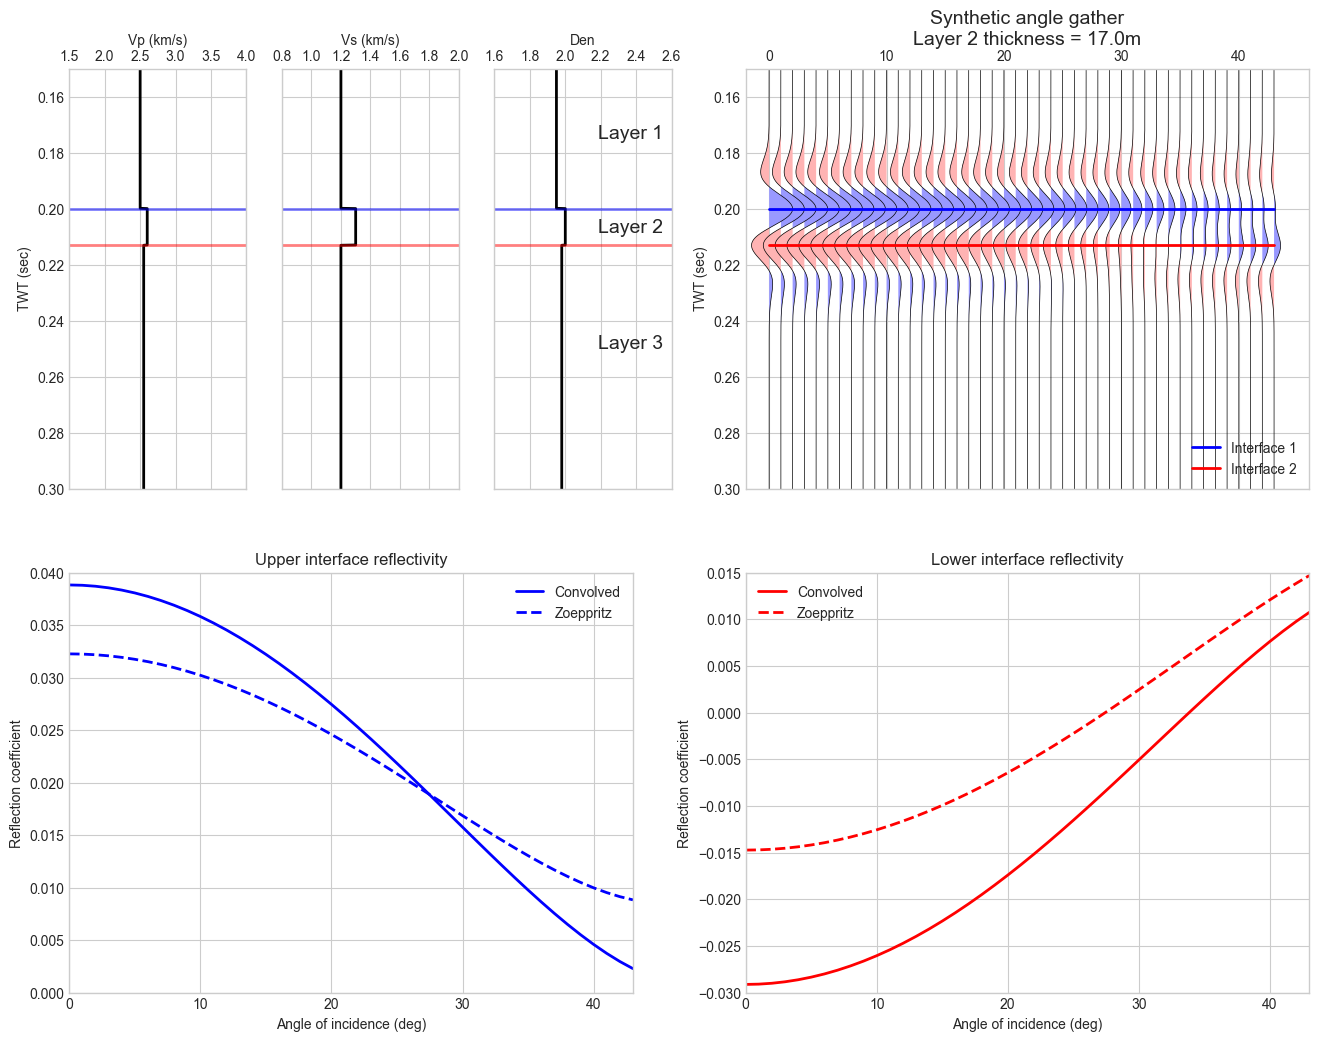

In [23]:
# CÉLULA 3 : PLOT AVO

plot_avo_prestack(
    syn_zoep_pp,    # Dados sísmicos sintéticos AVO.
    t,              # Vetor de tempo TWT.
    theta1,         # Vetor de ângulos de incidência.
    rc_zoep_pp,     # Coeficientes de Reflexão de Zoeppritz para as interfaces.
    line1,          # Amplitudes convoluídas (Interface Superior).
    line2,          # Amplitudes convoluídas (Interface Inferior).
    Azoep,          # Coeficientes AVO (NI e GRAD) obtidos da inversão Zoeppritz.
    Aconv,          # Coeficientes AVO (NI e GRAD) obtidos da inversão Convoluída.
    vp_dig,         # Modelo digital de Vp.
    vs_dig,         # Modelo digital de Vs.
    rho_dig,        # Modelo digital de Densidade.
    lyr_times,      # Tempos TWT das interfaces.
    ntrc,           # Número de traços (igual ao número de ângulos).
    thickness,      # Espessura da camada 2 para o título do Gather.
    excursion,      # Fator de escala para os wiggles.
    min_plot_time,  # Tempo TWT mínimo para o recorte visual.
    max_plot_time   # Tempo TWT máximo para o recorte visual.
)

### 5.2.1 - AVO + Logs: Vp + Vs + Den + Vp/Vs + Angle Gather + Upper and Lower Interface Reflectivity

### 5.2.0 - Computations | Definição de Plot

Computations

In [24]:
# COMPUTATIONS
# AVO + Logs Vp Vs Den Vp/Vs + Angle Gather + Upper and Lower Interface Reflectivity

import numpy as np
# Assuma que ricker, rc_zoep, calc_times, digitize_model, e as variáveis de PARÂMETROS GLOBAIS
# (vp_mod, dt, tmax, thickness, theta1_min, etc.) foram definidas em células anteriores.

# Parâmetros para AVO
theta1_min = 0.0    # Ângulo de incidência mínimo (graus)
theta1_max = 43.0   # Ângulo de incidência máximo (graus)
theta1_step = 1.0   # Passo do ângulo (graus)

# Espessura da camada 2 para o plot AVO (muitas vezes é o Tuning Thickness)
thickness = 17.0    # Espessura em metros

def create_digital_model(vp_mod, vs_mod, rho_mod, t, lyr1_indx, lyr2_indx):
    """
    Função auxiliar que cria o modelo de propriedades digitais (Vp, Vs, Rho)
    no domínio do tempo.
    """
    vp_dig = np.zeros(t.shape)
    vs_dig = np.zeros(t.shape)
    rho_dig = np.zeros(t.shape)

    # lyr1_indx e lyr2_indx são escalares para o modelo AVO
    vp_dig[0:lyr1_indx] = vp_mod[0]
    vp_dig[lyr1_indx:lyr2_indx] = vp_mod[1]
    vp_dig[lyr2_indx:] = vp_mod[2]

    vs_dig[0:lyr1_indx] = vs_mod[0]
    vs_dig[lyr1_indx:lyr2_indx] = vs_mod[1]
    vs_dig[lyr2_indx:] = vs_mod[2]

    rho_dig[0:lyr1_indx] = rho_mod[0]
    rho_dig[lyr1_indx:lyr2_indx] = rho_mod[1]
    rho_dig[lyr2_indx:] = rho_mod[2]
    
    return vp_dig, vs_dig, rho_dig


def calculate_avo_prestack(vp_mod, vs_mod, rho_mod, dt, wvlt_cfreq, wvlt_phase, wvlt_length, tmax, thickness, theta1_min, theta1_max, theta1_step, tmin):
    """
    Calcula o modelo sísmico AVO Prestack, incluindo RC's e Inversão Linear.
    Retorna todos os dados prontos para plotagem.
    """
    
    nangles = int((theta1_max - theta1_min) / theta1_step + 1)
    
    # Gerar Ricker Wavelet
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
    # Calcular Reflectividades (Zoeppritz)
    rc_zoep_pp = []
    theta1 = []
    for i in range(0, nangles):
        theta1_buf = i * theta1_step + theta1_min
        rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
        rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
        theta1.append(theta1_buf)
        rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])
        
    # Definir Vetor de Tempo (t)
    nsamp = int((tmax - tmin) / dt) + 1
    t = np.arange(tmin, tmax, dt)
    if len(t) < nsamp: t = np.append(t, t[-1] + dt)

    # Convolução (Synthetic Gather)
    syn_zoep_pp = []
    lyr_times = []
    dz_app = thickness
    
    for angle in range(0, nangles):
        z_int = [500.0, 500.0 + dz_app]
        t_int = calc_times(z_int, vp_mod)
        lyr_times.append(t_int)
        rc = digitize_model(rc_zoep_pp[angle], t_int, t)
        syn_buf = np.convolve(rc, wvlt_amp, mode='same')
        syn_zoep_pp.append(list(syn_buf))
        
    # Converter para numpy arrays e extrair amplitudes
    syn_zoep_pp = np.array(syn_zoep_pp)
    rc_zoep_pp = np.array(rc_zoep_pp)
    theta1 = np.array(theta1)
    lyr_times = np.array(lyr_times)
    lyr_indx = np.array(np.round(lyr_times / dt), dtype='int16')
    
    lyr1_indx_scalar = lyr_indx[0, 0] # Índice da Interface 1 no tempo
    lyr2_indx_scalar = lyr_indx[0, 1] # Índice da Interface 2 no tempo
    
    line1 = syn_zoep_pp[:, lyr1_indx_scalar]
    line2 = syn_zoep_pp[:, lyr2_indx_scalar]
    ntrc = syn_zoep_pp.shape[0]

    # AVO Inversion
    Yzoep = rc_zoep_pp[:, 0].reshape((ntrc, 1))
    Yconv = line1.reshape((ntrc, 1))
    ones = np.ones(ntrc).reshape((ntrc, 1))
    sintheta2 = np.sin(np.radians(theta1))**2 
    sintheta2 = sintheta2.reshape((ntrc, 1))
    X = np.hstack((ones, sintheta2))
    
    Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
    Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

    # Criar modelo de propriedade digital
    vp_dig, vs_dig, rho_dig = create_digital_model(vp_mod, vs_mod, rho_mod, t, lyr1_indx_scalar, lyr2_indx_scalar)

    # Retorna todos os dados necessários
    return syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc

# --- EXECUÇÃO DO CÁLCULO GERAL ---#

(syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc) = \
    calculate_avo_prestack(vp_mod, vs_mod, rho_mod, dt, wvlt_cfreq, wvlt_phase, wvlt_length, tmax, thickness, theta1_min, theta1_max, theta1_step, tmin)

Definições de Plot

In [25]:
# PLOT
# AVO + Logs Vp Vs Den Vp/Vs + Angle Gather + Upper and Lower Interface Reflectivity

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_avo_prestack(syn_zoep_pp, t, theta1, rc_zoep_pp, line1, line2, Azoep, Aconv, vp_dig, vs_dig, rho_dig, lyr_times, ntrc, thickness, excursion, min_plot_time, max_plot_time):
    """
    Plota o Painel AVO Prestack:
    LINHA SUPERIOR: 4 logs + Upper Interface Reflectivity
    LINHA INFERIOR: Gather + Lower Interface Reflectivity
    """

    # 1. Printar resultados da Inversão
    print('\n\n')
    print('  Method           NI             GRAD')
    print('---------------------------------------------------')
    print(f' Zoeppritz  {Azoep[0, 0]:11.5f}{Azoep[1, 0]:12.5f}')
    print(f' Convolved  {Aconv[0, 0]:10.5f}{Aconv[1, 0]:12.5f}')

    # 2. Criar a figura com gridspec:
    fig = plt.figure(figsize=(14, 10))
    fig.set_facecolor('white')
    
    # DEFINIR GRID - PROPORÇÕES E AJUSTES DA FIGURA GLOBAL AQUI:
    # LINHA SUPERIOR: 4 logs + Gather
    # LINHA INFERIOR: Upper Interface Reflectivity + Lower Interface Reflectivity
    # DEFINIR GRID - CONTROLE DE PROPORÇÕES
    gs = gridspec.GridSpec(2, 8, figure=fig, # Espaços: Linhas / Colunas
                      # Larguras relativas: [Log1, Log2, Log3, Log4, Gather]
                      # Definição de Proporções H
                      width_ratios=[1, 1, 1, 1, 1, 1, 1, 1],
                      # Definição de Proporções V
                      height_ratios=[1, 1],
                      # Espaços entre subplots
                      wspace=0.7, hspace=0.3)

   
    # 3. LINHA SUPERIOR: 4 LOGS + GATHER
    
    # Vp
    ax0a = fig.add_subplot(gs[0, 0]) # Log Vp Subplot (1/4)/7
    ax0a.plot(vp_dig/1000, t, 'k', lw=2)
    ax0a.set_ylim((min_plot_time, max_plot_time))
    ax0a.set_xlim(1.5, 4.0)
    ax0a.set_xticks(np.arange(1.5, 4.0 + 0.1, 0.5))
    ax0a.invert_yaxis()
    ax0a.set_ylabel('TWT (sec)')
    ax0a.xaxis.tick_top()
    ax0a.xaxis.set_label_position('top')
    ax0a.set_xlabel('Vp (km/s)', fontsize=10)
    ax0a.tick_params(axis='both', labelsize=8)
    ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0a.grid(True)

    # Vs
    ax0b = fig.add_subplot(gs[0, 1]) # Log Vs Subplot (2/4)/7
    ax0b.plot(vs_dig/1000, t, 'k', lw=2)
    ax0b.set_ylim((min_plot_time, max_plot_time))
    ax0b.set_xlim((0.8, 2.0))
    ax0b.set_xticks(np.arange(0.8, 2.0 + 0.1, 0.2))
    ax0b.invert_yaxis()
    # ax0b.set_ylabel('TWT (sec)')
    #ax0b.set_yticklabels('')
    ax0b.xaxis.tick_top()
    ax0b.xaxis.set_label_position('top')
    ax0b.set_xlabel('Vs (km/s)', fontsize=10)
    ax0b.tick_params(axis='both', labelsize=8)
    ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0b.grid(True)

    # Densidade
    ax0c = fig.add_subplot(gs[0, 2]) # Log Den Subplot (3/4)/7
    ax0c.plot(rho_dig, t, 'k', lw=2)
    ax0c.set_ylim((min_plot_time, max_plot_time))
    ax0c.set_xlim((1.6, 2.6))
    ax0c.set_xticks(np.arange(1.6, 2.6 + 0.1, 0.2))
    ax0c.invert_yaxis()
    # ax0c.set_ylabel('TWT (sec)')
    #ax0c.set_yticklabels('')
    ax0c.xaxis.tick_top()
    ax0c.xaxis.set_label_position('top')
    ax0c.set_xlabel('Den (g/cc)', fontsize=10)
    ax0c.tick_params(axis='both', labelsize=8)
    ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0c.grid(True)
    
    # Vp/Vs
    ax0d = fig.add_subplot(gs[0, 3]) # Log Vp/Vs Subplot (4/4)/7
    vp_vs = vp_dig / vs_dig
    ax0d.plot(vp_vs, t, 'k', lw=2)
    ax0d.set_ylim((min_plot_time, max_plot_time))
    ax0d.set_xlim((1.5, 3.0))
    ax0d.set_xticks(np.arange(1.5, 3.0 + 0.1, 0.3))
    ax0d.invert_yaxis()
    #ax0d.set_ylabel('TWT (sec)')
    #ax0d.set_yticklabels('')
    ax0d.xaxis.tick_top()
    ax0d.xaxis.set_label_position('top')
    ax0d.set_xlabel('Vp/Vs', fontsize=10)
    ax0d.tick_params(axis='both', labelsize=8)
    ax0d.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
    ax0d.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
    ax0d.grid(True)
    
    # Textos das camadas sendo usado sobre o log Vp/Vs
    y_text1 = min_plot_time + (lyr_times[0,0] - min_plot_time) * 0.3
    y_text2 = lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1]) * 0.5
    y_text3 = lyr_times[0,0] + (max_plot_time - lyr_times[0,0]) * 0.7
    
    ax0d.text(2.9, y_text1, 'Layer 1', fontsize=9, horizontalalignment='right', 
              verticalalignment='center', weight='bold')
    ax0d.text(2.9, y_text2, 'Layer 2', fontsize=9, horizontalalignment='right', 
              verticalalignment='center', weight='bold')
    ax0d.text(2.9, y_text3, 'Layer 3', fontsize=9, horizontalalignment='right', 
              verticalalignment='center', weight='bold')

    # GATHER (LINHA SUPERIOR)
    ax1 = fig.add_subplot(gs[0, 4:8]) # Gather Subplot 5/7
    plot_vawig(ax1, syn_zoep_pp, t, excursion)
    ax1.set_ylim((min_plot_time, max_plot_time))
    l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
    l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)
    plt.legend([l_int1, l_int2], ['Interface 1', 'Interface 2'], loc=4)
    ax1.invert_yaxis()
    label_str = f'SYNTHETIC ANGLE GATHER\nLayer 2 Thickness = {thickness:4.1f}m'
    ax1.set_xlabel(label_str, fontsize=12)
    ax1.tick_params(axis='both', labelsize=8)
    ax1.set_ylabel('TWT (sec)')   


    # 4. LINHA INFERIOR: UPPER REFLECTIVITY + LOWER REFLECTIVITY
    
    # UPPER REFLECTIVITY (LINHA INFERIOR)
    ax2 = fig.add_subplot(gs[1, 0:4]) # Upper Subplot 6/7
    
    l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
    l_rc1, = ax2.plot(rc_zoep_pp[:,0], '--', color='blue', lw=2)
    ax2.set_xlim((0, len(theta1) - 1))
    tick_positions = np.arange(0, len(theta1), 10)
    ax2.set_xticks(tick_positions)
    ax2.grid(True)
    ax2.set_xticklabels([f'{a:g}' for a in theta1[::10]]) 
    ax2.set_xlabel('Angle of Incidence (deg)')
    ax2.set_ylabel('Reflection Coefficient')
    ax2.set_title('UPPER INTERFACE REFLECTIVITY', fontsize=12, weight='bold')
    ax2.set_ylim(0.000, 0.040)
    ax2.tick_params(axis='both', labelsize=8)
    plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoeppritz'], loc=0)

    # LOWER REFLECTIVITY (LINHA INFERIOR)
    ax3 = fig.add_subplot(gs[1, 4:8]) # Lower Subplot 7/7
    
    l_syn2, = ax3.plot(line2, color='red', linewidth=2)
    l_rc2, = ax3.plot(rc_zoep_pp[:,1], '--', color='red', lw=2)
    ax3.set_xlim((0, len(theta1) - 1))
    ax3.set_xticks(tick_positions)
    ax3.set_xticklabels([f'{a:g}' for a in theta1[::10]]) 
    ax3.grid(True)
    ax3.set_xlabel('Angle of Incidence (deg)')
    ax3.set_ylabel('Reflection Coefficient')
    ax3.set_title('LOWER INTERFACE REFLECTIVITY', fontsize=12, weight='bold')
    ax3.set_ylim(-0.030, 0.015)
    ax3.tick_params(axis='both', labelsize=8)
    plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoeppritz'], loc=0)


    # Ajustar layout
    plt.subplots_adjust(left=0.05, right=0.98, bottom=0.08, top=0.92, hspace=0.2, wspace=0.4)
    plt.savefig('figure_2.2_AVO_Prestack_AVO_Tuning_Thin_Beds.png', dpi=500)#, bbox_inches='tight')
    plt.show()

### 5.2.2 - AVO + Logs: Vp + Vs + Den + Vp/Vs + Angle Gather + Upper and Lower Interface Reflectivity




  Method           NI             GRAD
---------------------------------------------------
 Zoeppritz      0.03144    -0.05412
 Convolved     0.03782    -0.08308


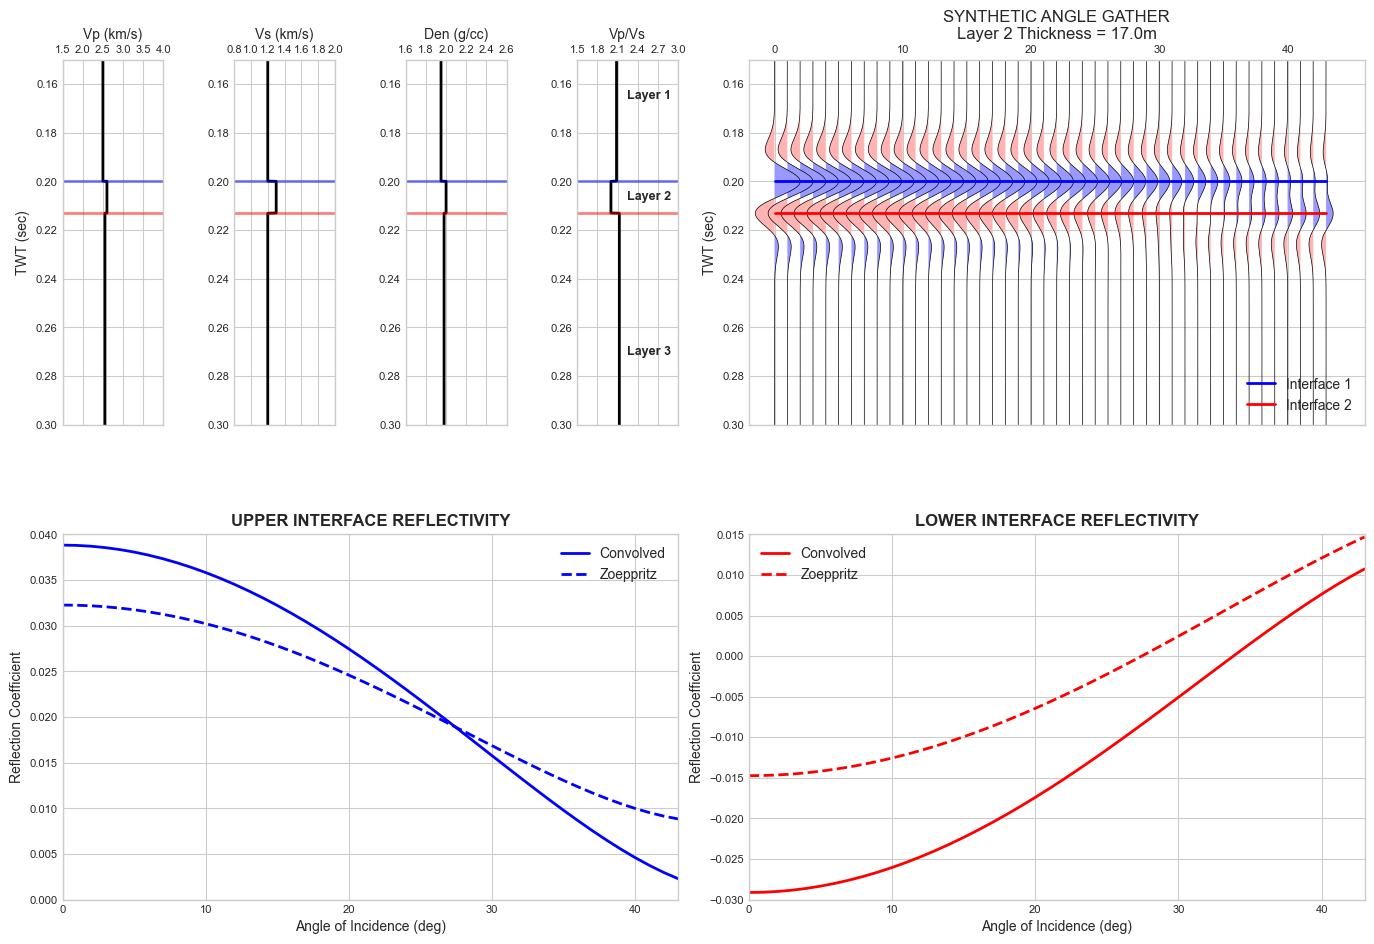

In [26]:
# PLOT AVO: AVO + Logs: Vp + Vs + Den + Vp/Vs + Angle Gather + Upper and Lower Interface Reflectivity

plot_avo_prestack(
    syn_zoep_pp,    # Dados sísmicos sintéticos AVO.
    t,              # Vetor de tempo TWT.
    theta1,         # Vetor de ângulos de incidência.
    rc_zoep_pp,     # Coeficientes de Reflexão de Zoeppritz para as interfaces.
    line1,          # Amplitudes convoluídas (Interface Superior).
    line2,          # Amplitudes convoluídas (Interface Inferior).
    Azoep,          # Coeficientes AVO (NI e GRAD) obtidos da inversão Zoeppritz.
    Aconv,          # Coeficientes AVO (NI e GRAD) obtidos da inversão Convoluída.
    vp_dig,         # Modelo digital de Vp.
    vs_dig,         # Modelo digital de Vs.
    rho_dig,        # Modelo digital de Densidade.
    lyr_times,      # Tempos TWT das interfaces.
    ntrc,           # Número de traços (igual ao número de ângulos).
    thickness,      # Espessura da camada 2 para o título do Gather.
    excursion,      # Fator de escala para os wiggles.
    min_plot_time,  # Tempo TWT mínimo para o recorte visual.
    max_plot_time   # Tempo TWT máximo para o recorte visual.
)

#### 🖼️ Guia de Análise Visual dos Gráficos

A figura gerada possui quatro painéis principais que ilustram o modelo, a resposta sísmica e o efeito do tuning no domínio AVO.

| Painel | Descrição | O que observar (Tuning) |
| :---: | :---: | :---: |
| **Gráfico 1** | Logs de Propriedades (*Vp*, *Vs*, *Rho*). | A **espessura** da Camada 2 (17m), que é a causa do tuning. |
| **Gráfico 2** | **Gather Sísmico Sintético** (*V.A.Wig*). | A **interferência** das reflexões da interface superior e inferior, especialmente nos ângulos de incidência maiores. |
| **Gráficos 3 e 4** | Curvas AVO (*Refletividade* vs. *Ângulo*). | A **divergência** entre a linha tracejada (**Zoeppritz**) e a linha sólida (**Convolved**), que quantifica visualmente o efeito tuning. |

### 5.3 - Interpretações e Exemplos

#### 5.4 - Computations | Definição de Plot : Classificação AVO

In [72]:
def plot_avo_classification(Azoep, Aconv):
    """
    Plota o Crossplot de Classificação AVO com baseline k = -1.0
    """
    
    # 1. Crossplot
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.set_facecolor('white')
    
    # 2. Preparar os vetores para as linhas de classificação
    # Calcular range dos eixos:
    max_abs = np.max(np.abs([Azoep[0, 0], Azoep[1, 0], Aconv[0, 0], Aconv[1, 0]])) * 1.8
    ni_range = np.linspace(-max_abs, max_abs, 100)
    
    # 3. CÁLCULO DA BASELINE:
    # Linhas de Referência - Baseline (Shale) -  k = -1.0 (valor comum para shale)
    k_baseline = -1.0  # Ajuste conforme seu caso
    grad_baseline = k_baseline * ni_range
        
     # 4. LINHAS GUIA DOS QUADRANTES: NI=0 e GRAD=0 - Linha dos Eixos:
    ax.axhline(0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axvline(0, color='gray', linestyle='-', linewidth=1.5, alpha=0.7)
    
    
    # 5. PLOTAGEM DA BASELINE: linha tracejada preta
    ax.plot(ni_range, grad_baseline, 'k--', linewidth=2.5, 
            label=f'Shale Baseline ( k = {k_baseline} )') # Legenda
    
    # 6. Plotar os pontos AVO
    ax.plot(Azoep[0, 0], Azoep[1, 0], 'bo', markersize=10, 
            label=f'Zoeppritz:   NI = {Azoep[0, 0]:.4f}    GRAD = {Azoep[1, 0]:.4f}') # Legenda
    ax.plot(Aconv[0, 0], Aconv[1, 0], 'ro', markersize=10, 
            label=f'Convolved: NI = {Aconv[0, 0]:.4f}    GRAD = {Aconv[1, 0]:.4f}') # Legenda
    
    # 7. Ajustes Visuais
    ax.set_xlim(-max_abs, max_abs)
    ax.set_ylim(-max_abs, max_abs)
    ax.set_xlabel('Intercept (NI)', fontsize=12, weight='bold')
    ax.set_ylabel('Gradient (GRAD)', fontsize=12, weight='bold')
    ax.set_title('AVO Classification Crossplot\n(Rutherford & Williams, 1989', 
                 fontsize=14, weight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)

    # 8. RÓTULOS DOS QUADRANTES AVO
    text_offset = max_abs * 0.15
    
    # Quadrante I: NI > 0, GRAD > 0
    ax.text(max_abs*0.7, max_abs*0.45, 'CLASS I\nHigh Impedance', 
            ha='center', va='center', fontsize=11, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    
    # Quadrante II: NI > 0, GRAD < 0  
    ax.text(max_abs*0.7, -max_abs*0.45, 'CLASS II\nNear Zero\nImpedance', 
            ha='center', va='center', fontsize=11, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
    
    # Quadrante III: NI < 0, GRAD < 0
    ax.text(-max_abs*0.7, -max_abs*0.45, 'CLASS III\nLow Impedance\n(Bright Spot)', 
            ha='center', va='center', fontsize=11, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))
    
    # Quadrante IV: NI < 0, GRAD > 0
    ax.text(-max_abs*0.7, max_abs*0.45, 'CLASS IV\nPolarity\nReversal', 
            ha='center', va='center', fontsize=11, weight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

    # 9. Anotação técnica:
    # COMPORTAMENTO SEGUNDO MODELO DE BASE USADO:
    ax.text(0.5, 0.05, '▲ Class II Behavior - Typical for Thin Bed Tuning', 
        transform=ax.transAxes, fontsize=11, weight='bold', 
        ha='center', color='darkgreen',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.9))
    
    ax.text(0.1, 0.98, f'Baseline: k = {k_baseline} (typical shale)',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
   
    # 10. Salvar e mostrar
    plt.tight_layout()
    plt.savefig('figure_3.0_AVO_Classification_Crossplot.png', dpi=600, bbox_inches='tight')
    plt.show()

    # Plot
    # plot_avo_classification(Azoep, Aconv)

### 5.5 - Plot: Classificação AVO

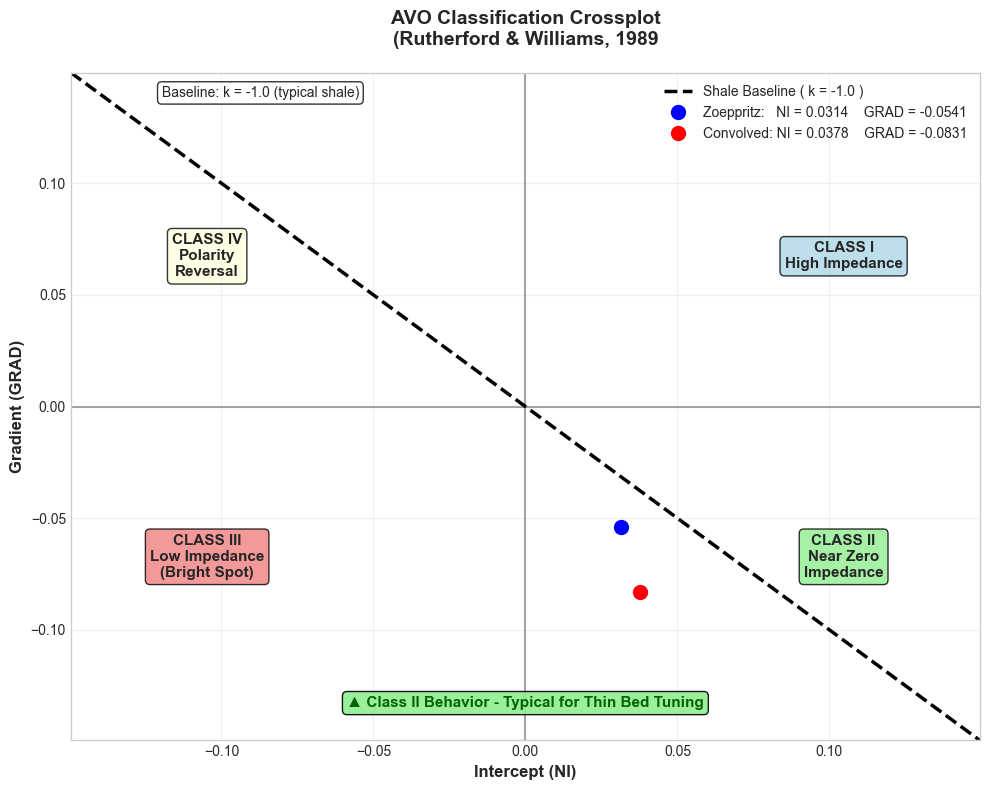

In [73]:
# Plot Classificação AVO
plot_avo_classification(Azoep, Aconv)

---
## 🎯 **PARÂMETROS DO MODELO**
- **Espessura da camada**: `17.0 m`  
- **Baseline de referência**: `k = -1.0` (shale típico)  
- **Comportamento**: **Thin Bed Tuning**  

---

## 📈 **COEFICIENTES AVO OBTIDOS**

### **NI (Intercept)**
- **Valor**: `0.0314`
- **Significado**: Coeficiente de reflexão em ângulo zero  
- **Interpretação**: 🔼 **Positivo** → Camada 2 tem **impedância MAIOR** que camada 1

### **GRAD (Gradient)**
- **Zoeppritz**: `-0.0541`
- **Convolved**: `-0.0831`  
- **Significado**: Taxa de variação da amplitude com ângulo  
- **Interpretação**: 🔽 **Negativo** → Amplitudes **DIMINUEM** com aumento do ângulo

---

## 🏷️ **CLASSIFICAÇÃO AVO**

### **CLASSE II** - *Near Zero Impedance*
- ✅ **NI > 0** e **GRAD < 0**
- 🎯 Comportamento típico de reservatórios com **pequeno contraste de impedância**
- 📊 Característico de **thin beds** e **efeitos de tuning**

---

## 🔍 **INTERPRETAÇÃO GEOFÍSICA**

- 📍 Pontos localizados **ABAIXO** da baseline de shale
- ⚡ Comportamento mais "gasoso" que shale típico
- 🔄 Diferença entre Zoeppritz/Convolved mostra **limitação da resolução sísmica**
- 🎯 **Class II** é indicativo de **camadas delgadas** com interferência

---

## 📝 **EQUAÇÃO AVO**
RC(θ) ≈ NI + GRAD × sin²(θ)

Onde:  
- `θ` = ângulo de incidência  
- `NI` = Intercept (reflexão em ângulo zero)  
- `GRAD` = Gradient (variação com ângulo)